# Notebook 3: Transfer Learning con MobileNetV2

## ¿Qué hace este notebook?
Usamos un modelo **pre-entrenado** llamado MobileNetV2 que ya aprendió a reconocer miles de objetos con millones de imágenes. En lugar de empezar desde cero, aprovechamos ese conocimiento previo.

## ¿Qué es Transfer Learning?
Es como aprender a conducir una moto después de saber andar en bicicleta: no empiezas de cero porque ya tienes habilidades transferibles.

## Dos estrategias probadas:
1. **Feature Extraction**: Congelamos el modelo pre-entrenado y solo entrenamos la parte final
2. **Fine Tuning**: Descongelamos algunas capas para adaptarlas a nuestras imágenes

## Resultados Obtenidos
| Estrategia | Precisión en Test |
|------------|------------------|
| Feature Extraction | 94.25% |
| Fine Tuning | 17.46% |

⚠️ El Fine Tuning falló debido a sobreajuste. Se recomienda usar tasa de aprendizaje más baja.

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configuración
DATASET_DIR = 'dataset_split'
IMG_SIZE = (160, 160) # MobileNetV2 expects 160x160 or similar
BATCH_SIZE = 32
EPOCHS_FE = 5
EPOCHS_FT = 5
CLASSES = ['cavallo', 'elefante', 'gallina', 'mucca', 'pecora']

2025-12-16 21:17:04.266063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 21:17:04.672793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 21:17:06.259735: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Carga de Datos y Preprocesamiento

In [3]:
def load_data():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'val'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'test'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False
    )
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()

Found 3615 files belonging to 5 classes.
Found 1805 files belonging to 5 classes.
Found 1810 files belonging to 5 classes.


2025-12-16 21:17:08.396522: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 1. Feature Extraction

In [4]:
# Pre-processing pipeline
preprocess_layer = preprocess_input # MobileNetV2 expects [-1, 1] range

# Base Model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False # FREEZE

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = preprocess_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
print("Training Feature Extraction...")
history_fe = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FE)

# Guardar resultados preliminares
loss0, accuracy0 = model.evaluate(test_ds)
print(f"Initial Test Accuracy: {accuracy0*100:.2f}%")

Training Feature Extraction...
Epoch 1/5


2025-12-16 20:50:57.779666: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26214400 exceeds 10% of free system memory.
2025-12-16 20:50:57.870039: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 26214400 exceeds 10% of free system memory.
2025-12-16 20:50:57.922048: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 78643200 exceeds 10% of free system memory.
2025-12-16 20:50:58.002675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 80621568 exceeds 10% of free system memory.
2025-12-16 20:50:58.061106: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 19660800 exceeds 10% of free system memory.


 68/113 ━━━━━━━━━━━━━━━━━━━━ 25s 577ms/step - accuracy: 0.6726 - loss: 0.8794

2025-12-16 20:51:37.173188: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 861ms/step - accuracy: 0.8539 - loss: 0.4275 - val_accuracy: 0.9285 - val_loss: 0.2178
Epoch 2/5
 89/113 ━━━━━━━━━━━━━━━━━━━━ 23s 992ms/step - accuracy: 0.9395 - loss: 0.1712

2025-12-16 20:54:03.549735: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9386 - loss: 0.1824 - val_accuracy: 0.9363 - val_loss: 0.1902
Epoch 3/5
 69/113 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.9597 - loss: 0.1258

2025-12-16 20:55:30.321610: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 619ms/step - accuracy: 0.9555 - loss: 0.1368 - val_accuracy: 0.9380 - val_loss: 0.1801
Epoch 4/5
 66/113 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - accuracy: 0.9663 - loss: 0.1088

2025-12-16 20:59:43.029943: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9627 - loss: 0.1158 - val_accuracy: 0.9391 - val_loss: 0.1735
Epoch 5/5
 70/113 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9752 - loss: 0.0856

2025-12-16 21:00:30.615403: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 413ms/step - accuracy: 0.9654 - loss: 0.1028 - val_accuracy: 0.9396 - val_loss: 0.1718
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.9425 - loss: 0.1763
Initial Test Accuracy: 94.25%


## 2. Fine Tuning

In [5]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-5), # Low learning rate
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 1,867,845 (7.13 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [6]:
print("Training Fine Tuning...")
total_epochs = EPOCHS_FE + EPOCHS_FT

history_ft = model.fit(train_ds,
                       validation_data=val_ds,
                       epochs=total_epochs,
                       initial_epoch=history_fe.epoch[-1])

Training Fine Tuning...
Epoch 5/10
 88/113 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8554 - loss: 0.3990

2025-12-16 21:03:58.338676: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8769 - loss: 0.3469 - val_accuracy: 0.9391 - val_loss: 0.1763
Epoch 6/10
 72/113 ━━━━━━━━━━━━━━━━━━━━ 26s 636ms/step - accuracy: 0.9172 - loss: 0.2329

2025-12-16 21:05:20.974769: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 92s 813ms/step - accuracy: 0.9217 - loss: 0.2246 - val_accuracy: 0.9385 - val_loss: 0.1772
Epoch 7/10
 72/113 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - accuracy: 0.9384 - loss: 0.1676

2025-12-16 21:06:51.836300: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 89s 789ms/step - accuracy: 0.9422 - loss: 0.1632 - val_accuracy: 0.9407 - val_loss: 0.1749
Epoch 8/10
 82/113 ━━━━━━━━━━━━━━━━━━━━ 18s 597ms/step - accuracy: 0.9580 - loss: 0.1295

2025-12-16 21:08:24.928066: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 87s 770ms/step - accuracy: 0.9582 - loss: 0.1313 - val_accuracy: 0.9424 - val_loss: 0.1798
Epoch 9/10
 69/113 ━━━━━━━━━━━━━━━━━━━━ 27s 618ms/step - accuracy: 0.9680 - loss: 0.1040

2025-12-16 21:09:45.514843: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 795ms/step - accuracy: 0.9665 - loss: 0.1063 - val_accuracy: 0.9457 - val_loss: 0.1796
Epoch 10/10
 68/113 ━━━━━━━━━━━━━━━━━━━━ 28s 627ms/step - accuracy: 0.9728 - loss: 0.0872

2025-12-16 21:11:15.151734: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 800ms/step - accuracy: 0.9732 - loss: 0.0914 - val_accuracy: 0.9457 - val_loss: 0.1810


## Evaluación Final

Evaluating MobileNetV2_FineTuned...
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.1746 - loss: 2.4114
MobileNetV2_FineTuned Test Accuracy: 17.46%


2025-12-16 21:18:10.085060: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


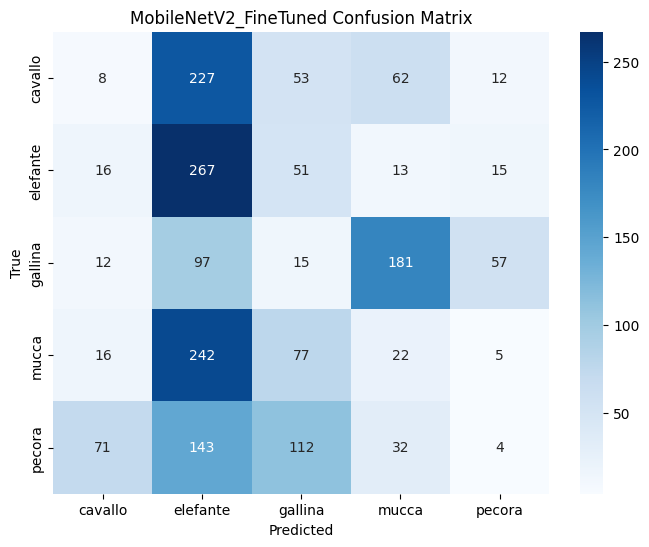

              precision    recall  f1-score   support

     cavallo       0.07      0.02      0.03       362
    elefante       0.27      0.74      0.40       362
     gallina       0.05      0.04      0.04       362
       mucca       0.07      0.06      0.07       362
      pecora       0.04      0.01      0.02       362

    accuracy                           0.17      1810
   macro avg       0.10      0.17      0.11      1810
weighted avg       0.10      0.17      0.11      1810



In [5]:
def evaluate_model(model, name):
    print(f"Evaluating {name}...")
    loss, accuracy = model.evaluate(test_ds)
    print(f"{name} Test Accuracy: {accuracy*100:.2f}%")
    
    y_pred = np.array([])
    y_true = np.array([])
    for x, y in test_ds:
        preds = model.predict(x, verbose=0)
        y_pred = np.concatenate([y_pred, np.argmax(preds, axis=1)])
        y_true = np.concatenate([y_true, np.argmax(y, axis=1)])
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=CLASSES))

evaluate_model(model, "MobileNetV2_FineTuned")